In [8]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, r2_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor


from sklearn.preprocessing import LabelEncoder

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.options.display.max_columns = None

from IPython.display import display
from IPython.display import Image

import pydotplus
import joblib


In [9]:
df_train = pd.read_csv("https://raw.githubusercontent.com/claudia-ramos/7506R-1C2024-GRUPO3/main/Datasets/df_train.csv")
price_train = pd.read_csv("https://raw.githubusercontent.com/claudia-ramos/7506R-1C2024-GRUPO3/main/Datasets/price_train.csv")
price_test = pd.read_csv("https://raw.githubusercontent.com/claudia-ramos/7506R-1C2024-GRUPO3/main/Datasets/price_test.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/claudia-ramos/7506R-1C2024-GRUPO3/main/Datasets/df_test.csv")

In [10]:
df_train = df_train.set_index('Unnamed: 0')
df_train.index.name = None

price_train = price_train.set_index('Unnamed: 0')
price_train.index.name = None

price_test = price_test.set_index('Unnamed: 0')
price_test.index.name = None

df_test = df_test.set_index('Unnamed: 0')
df_test.index.name = None

# **Clasificación**

Con el objetivo de clasificar los anuncios de viviendas por su precio se creará una nueva variable "tipo_precio", la cual tendrá tres categorías: alto, medio y bajo. Para determinar el tipo_precio de una propiedad se analizará el precio por metro cuadrado ('pxm2')

In [11]:
# Agrego columna 'pxm2'
df_con_pxm2_aux = pd.concat([df_train, price_train], axis=1)
df_con_pxm2 = df_con_pxm2_aux.copy()
df_con_pxm2['pxm2'] = round(df_con_pxm2['property_price']/df_con_pxm2['property_surface_total'],2)
df_con_pxm2 = df_con_pxm2.drop(columns=['property_price'])

In [12]:
df_con_pxm2

latitud   longitud  property_rooms  property_bedrooms  \
11076  -34.228218 -59.554097             5.0                4.0   
97969  -34.589855 -58.406316             5.0                3.0   
453080 -34.623850 -58.377764             2.0                1.0   
277802 -34.573932 -58.474268             1.0                1.0   
97709  -34.621109 -58.466048             2.0                1.0   
...           ...        ...             ...                ...   
449859 -34.559587 -58.473910             3.0                2.0   
203156 -34.624150 -58.404265             2.0                1.0   
445146 -34.545798 -58.469623             1.0                1.0   
332847 -34.644207 -58.498511             3.0                2.0   
35541  -34.577837 -58.495647             2.0                1.0   

        property_surface_total  property_surface_covered  type_casa  \
11076                    202.0                     182.0          0   
97969                    127.0                     103.0          0   
453080                    44.0                      42.0          0   
277802                    34.0                      28.0          0   
97709                     41.0                      41.0          0   
...                        ...                       ...        ...   
449859                    63.0                      58.0          0   
203156                    89.0                      89.0          0   
445146                    35.0                      32.0          0   
332847                    73.0                      73.0          0   
35541                     72.0                      51.0          0   

        type_dpto  barrio_Palermo  barrio_Belgrano  barrio_Recoleta  \
11076           1               0                0                1   
97969           1               0                0                1   
453080          1               0                0                0   
277802          1               0                0                0   
97709           1               0                0                0   
...           ...             ...              ...              ...   
449859          1               0                0                0   
203156          1               0                0                0   
445146          1               0                0                0   
332847          0               0                0                0   
35541           1               0                0                0   

        barrio_Caballito  barrio_Villa_Urquiza  barrio_Almagro     pxm2  
11076                  0                     0               0  2128.71  
97969                  0                     0               0  3307.09  
453080                 0                     0               0  1477.27  
277802                 0                     1               0  2150.00  
97709                  0                     0               0  1658.54  
...                  ...                   ...             ...      ...  
449859                 0                     0               0  2063.49  
203156                 0                     0               0  1459.55  
445146                 0                     0               0  2542.86  
332847                 0                     0               0  1849.32  
35541                  0                     1               0  2013.89  

[72364 rows x 15 columns]

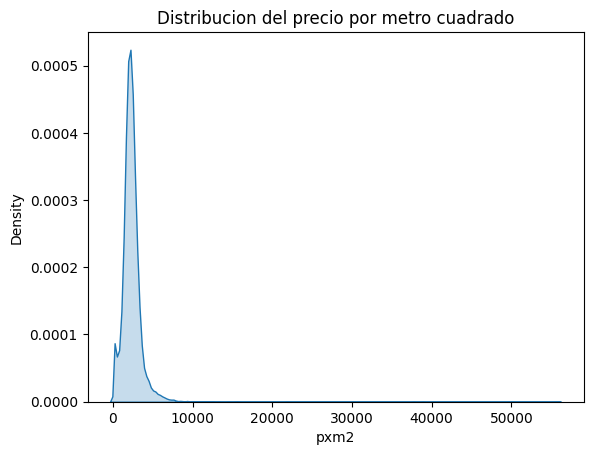

In [13]:
sns.kdeplot(df_con_pxm2['pxm2'], fill=True)
plt.title("Distribucion del precio por metro cuadrado")
plt.show()

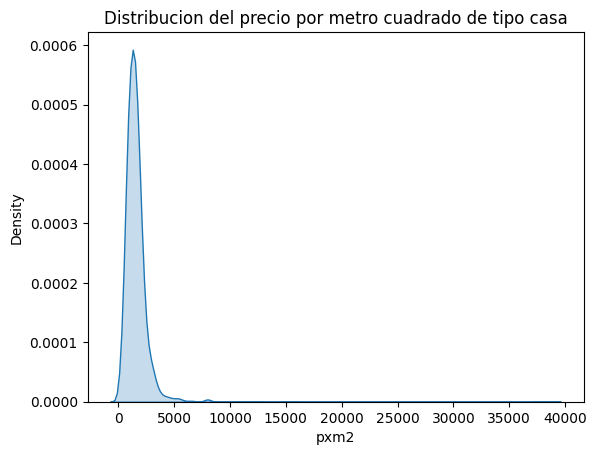

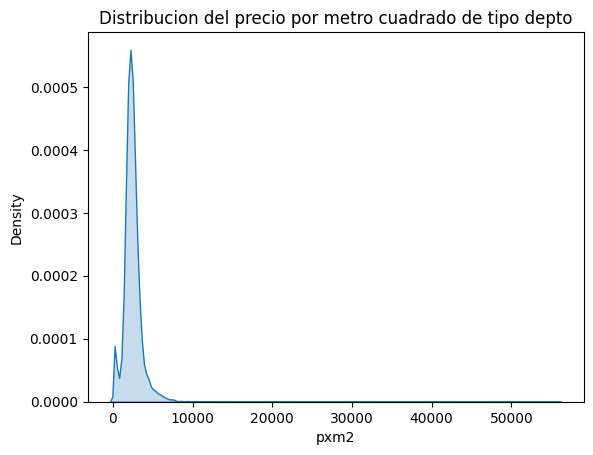

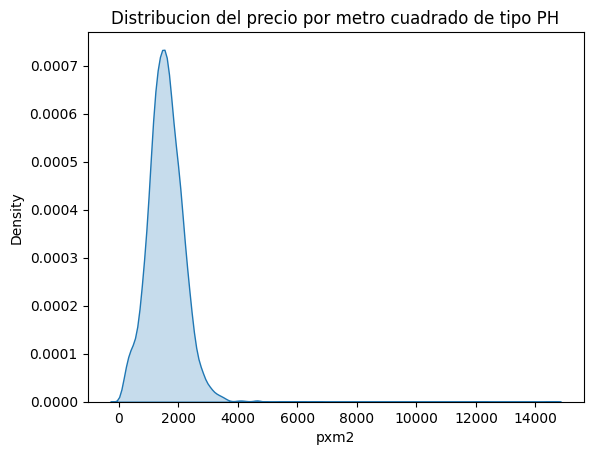

In [14]:
# dist precio por metro cuadrado por tipo de propiedad

sns.kdeplot(x=df_con_pxm2.query('type_casa == 1')["pxm2"], fill=True)
plt.title("Distribucion del precio por metro cuadrado de tipo casa")
plt.show()

sns.kdeplot(x=df_con_pxm2.query('type_dpto == 1')["pxm2"], fill=True)
plt.title("Distribucion del precio por metro cuadrado de tipo depto")
plt.show()

sns.kdeplot(x=df_con_pxm2.query('type_dpto == 0 & type_casa == 0')["pxm2"], fill=True)
plt.title("Distribucion del precio por metro cuadrado de tipo PH")
plt.show()

## Targets

 ### 3 intervalos con igual cantidad de observaciones

Primero vemos como quedaría la variable tipo_precio determinando el tipo de precio dividiendo la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

<Axes: title={'center': 'Distribución variable tipo_precio'}, xlabel='tipo_precio'>

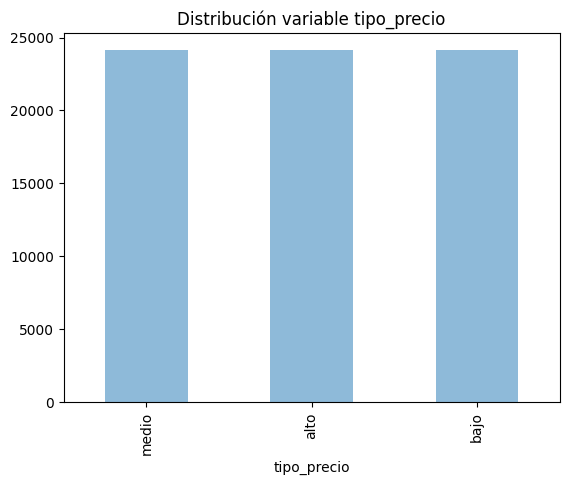

In [15]:
# Dividiendo en 3 intervalos con igual cantidad de observaciones
df_precios_altos = df_con_pxm2.sort_values('pxm2').tail(int(df_con_pxm2.shape[0]/3)) # dividimos en
df_precios_bajos = df_con_pxm2.sort_values('pxm2').head(int(df_con_pxm2.shape[0]/3)) # 3 partes iguales
df_3_int_iguales = df_con_pxm2.assign(precio_alto= df_con_pxm2.index.isin(df_precios_altos.index).astype(int))
df_3_int_iguales = df_3_int_iguales.assign(precio_bajo= df_con_pxm2.index.isin(df_precios_bajos.index).astype(int))

df_3_int_iguales['tipo_precio'] = df_3_int_iguales['precio_alto'] - df_3_int_iguales['precio_bajo']
df_3_int_iguales['tipo_precio'] = df_3_int_iguales['tipo_precio'].apply(lambda x: 'alto' if x == 1 else ('bajo' if x == -1 else 'medio'))
columnas_precios = ['precio_alto','precio_bajo']
df_3_int_iguales.drop(columnas_precios, axis="columns", inplace=True)

# Gráfico de la distribución de la variable
df_3_int_iguales['tipo_precio'].value_counts().plot.bar(alpha=0.5 , title="Distribución variable tipo_precio")



###3 intervalos 25%-50%-25%

Luego, vemos como quedaría la nueva variable tipo_precio determinando el tipo de precio dividiendo la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones,
el siguiente con el 50% y el último con el 25% de las observaciones restantes.

<Axes: title={'center': 'Distribución variable tipo_precio '}, xlabel='tipo_precio'>

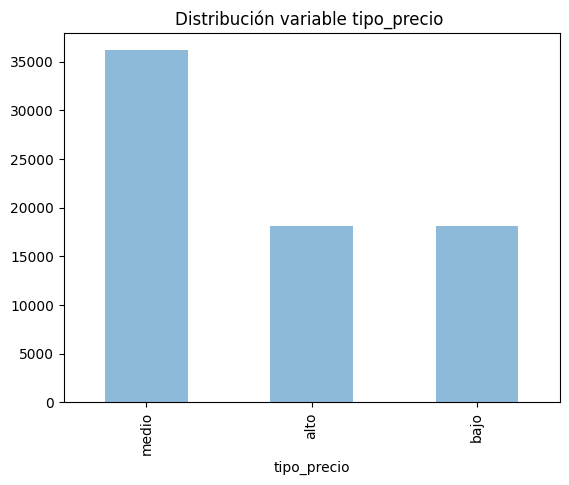

In [16]:
# Dividiendo en intervalos de 25%, 50% y 25% de observaciones
df_precios_altos = df_con_pxm2.sort_values('pxm2').tail(int(df_con_pxm2.shape[0]/4))
df_precios_bajos = df_con_pxm2.sort_values('pxm2').head(int(df_con_pxm2.shape[0]/4))
df_25_50_25 = df_con_pxm2.assign(precio_alto= df_con_pxm2.index.isin(df_precios_altos.index).astype(int))
df_25_50_25 = df_25_50_25.assign(precio_bajo= df_con_pxm2.index.isin(df_precios_bajos.index).astype(int))

df_25_50_25['tipo_precio'] = df_25_50_25['precio_alto'] - df_25_50_25['precio_bajo']
df_25_50_25['tipo_precio'] = df_25_50_25['tipo_precio'].apply(lambda x: 'alto' if x == 1 else ('bajo' if x == -1 else 'medio'))
columnas_precios = ['precio_alto','precio_bajo']
df_25_50_25.drop(columnas_precios,axis="columns", inplace=True)

# Gráfico de la distribución de la variable 'tipo_precio'
df_25_50_25['tipo_precio'].value_counts().plot.bar(alpha=0.5 , title="Distribución variable tipo_precio ")

### pxm2 relativa a cada tipo de propiedad

Por último, vemos como quedaría la nueva variable tipo_precio determinando el tipo de precio trabajando la variable pxm2 relativa a cada tipo de propiedad y luego dividiendola como en
el punto anterior.

<Axes: title={'center': 'Distribucion variable tipo_precio '}, xlabel='tipo_precio'>

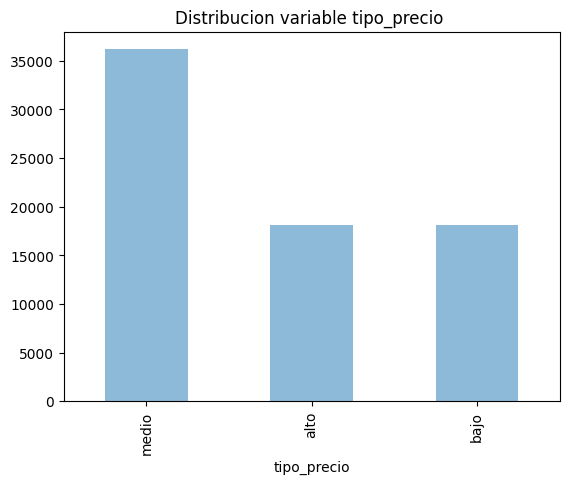

In [17]:
# Trabajando la variable 'pxm2' relativa a cada tipo de propiedad
# y dividiendo en intervalos de 25%, 50% y 25% de observaciones
df_precios_altos_casas = df_con_pxm2.query('type_casa == 1').sort_values('pxm2').tail(int(df_con_pxm2.query('type_casa == 1').shape[0]/4))
df_precios_bajos_casas = df_con_pxm2.query('type_casa == 1').sort_values('pxm2').head(int(df_con_pxm2.query('type_casa == 1').shape[0]/4))

df_precios_altos_deptos = df_con_pxm2.query('type_dpto == 1').sort_values('pxm2').tail(int(df_con_pxm2.query('type_dpto == 1').shape[0]/4))
df_precios_bajos_deptos = df_con_pxm2.query('type_dpto == 1').sort_values('pxm2').head(int(df_con_pxm2.query('type_dpto == 1').shape[0]/4))

df_precios_altos_ph = df_con_pxm2.query('type_dpto == 0 & type_casa == 0').sort_values('pxm2').tail(int(df_con_pxm2.query('type_dpto == 0 & type_casa == 0').shape[0]/4))
df_precios_bajos_ph = df_con_pxm2.query('type_dpto == 0 & type_casa == 0').sort_values('pxm2').head(int(df_con_pxm2.query('type_dpto == 0 & type_casa == 0').shape[0]/4))

df_precios_altos = pd.concat([pd.concat([df_precios_altos_casas, df_precios_altos_deptos]), df_precios_altos_ph])
df_precios_bajos = pd.concat([pd.concat([df_precios_bajos_casas, df_precios_bajos_deptos]), df_precios_bajos_ph])

df_por_tipo_propiedad = df_con_pxm2.assign(precio_alto= df_con_pxm2.index.isin(df_precios_altos.index).astype(int))
df_por_tipo_propiedad = df_por_tipo_propiedad.assign(precio_bajo= df_con_pxm2.index.isin(df_precios_bajos.index).astype(int))


df_por_tipo_propiedad['tipo_precio'] = df_por_tipo_propiedad['precio_alto'] - df_por_tipo_propiedad['precio_bajo']
df_por_tipo_propiedad['tipo_precio'] = df_por_tipo_propiedad['tipo_precio'].apply(lambda x: 'alto' if x == 1 else ('bajo' if x == -1 else 'medio'))
columnas_precios = ['precio_alto','precio_bajo']
df_por_tipo_propiedad.drop(columnas_precios, axis="columns", inplace=True)

# Gráfico de la distribución de la variable 'tipo_precio'
df_por_tipo_propiedad['tipo_precio'].value_counts().plot.bar(alpha=0.5 , title="Distribucion variable tipo_precio ")

Seleccionamos la alternativa donde trabajamos la variable pxm2 relativa a cada tipo de propiedad, ya que consideramos el tipo de precio depende del tipo de propiedad del anuncio.

##Agrupamiento por K Means

In [18]:
df_analisis_kmeans = df_con_pxm2.copy()
df_analisis_kmeans['barrio'] = (df_analisis_kmeans['barrio_Palermo'] - df_analisis_kmeans['barrio_Belgrano'] -
    2*(df_analisis_kmeans['barrio_Recoleta']) - 3*(df_analisis_kmeans['barrio_Caballito']) - 4*(df_analisis_kmeans['barrio_Villa_Urquiza']) -
    5*(df_analisis_kmeans['barrio_Almagro']))
df_analisis_kmeans['barrio'] = df_analisis_kmeans['barrio'].apply(lambda x: 1 if x == 1 else (2 if x == -1 else
        (3 if x == -2 else (4 if x == -3 else (5 if x == -4 else (6 if x == -5 else 7))))))

df_analisis_kmeans['tipo_prop'] = df_analisis_kmeans['type_casa'] - df_analisis_kmeans['type_dpto']
df_analisis_kmeans['tipo_prop'] = df_analisis_kmeans['tipo_prop'].apply(lambda x: 1 if x == 1 else (2 if x == -1 else 0))

columnas_a_eliminar = ['barrio_Palermo', 'barrio_Belgrano','barrio_Recoleta','barrio_Caballito','barrio_Villa_Urquiza','barrio_Almagro','type_casa','type_dpto']
df_analisis_kmeans.drop(columnas_a_eliminar, axis="columns", inplace=True)

In [19]:
df_analisis_kmeans

latitud   longitud  property_rooms  property_bedrooms  \
11076  -34.228218 -59.554097             5.0                4.0   
97969  -34.589855 -58.406316             5.0                3.0   
453080 -34.623850 -58.377764             2.0                1.0   
277802 -34.573932 -58.474268             1.0                1.0   
97709  -34.621109 -58.466048             2.0                1.0   
...           ...        ...             ...                ...   
449859 -34.559587 -58.473910             3.0                2.0   
203156 -34.624150 -58.404265             2.0                1.0   
445146 -34.545798 -58.469623             1.0                1.0   
332847 -34.644207 -58.498511             3.0                2.0   
35541  -34.577837 -58.495647             2.0                1.0   

        property_surface_total  property_surface_covered     pxm2  barrio  \
11076                    202.0                     182.0  2128.71       3   
97969                    127.0                     103.0  3307.09       3   
453080                    44.0                      42.0  1477.27       7   
277802                    34.0                      28.0  2150.00       5   
97709                     41.0                      41.0  1658.54       7   
...                        ...                       ...      ...     ...   
449859                    63.0                      58.0  2063.49       7   
203156                    89.0                      89.0  1459.55       7   
445146                    35.0                      32.0  2542.86       7   
332847                    73.0                      73.0  1849.32       7   
35541                     72.0                      51.0  2013.89       5   

        tipo_prop  
11076           2  
97969           2  
453080          2  
277802          2  
97709           2  
...           ...  
449859          2  
203156          2  
445146          2  
332847          0  
35541           2  

[72364 rows x 9 columns]

In [20]:
#sns.pairplot(df_analisis_kmeans.select_dtypes(include=['float64', 'int64']))

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import silhouette_score

In [22]:
def vector_creator(x,y,df):
    ys=df[y].values
    xs=df[x].values
    vector= [[xs[i], ys[i]] for i in range(len(ys))]
    return vector,xs,ys

In [23]:
def scatter_cluster(cart,x_vector,y_vector,clust):
    kmeans = KMeans(n_clusters=clust)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento
    kmeans.fit(cart) #Entrenamos el algoritmo para que aprenda cómo agrupar
    y_kmeans = kmeans.predict(cart)
    plt.scatter(x_vector, y_vector, c=y_kmeans, s=50, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,marker='.')
    plt.show()
    return y_kmeans

In [24]:
df_pxm2_kmeans = df_con_pxm2.copy()

In [25]:
df_pxm2_kmeans['tipo_prop'] = df_pxm2_kmeans['type_casa'] - df_pxm2_kmeans['type_dpto']
df_pxm2_kmeans['tipo_prop'] = df_pxm2_kmeans['tipo_prop'].apply(lambda x: 1 if x == 1 else (2 if x == -1 else 0))

Agrupamiento segun precio por metro cuadrado y tipo de propiedad


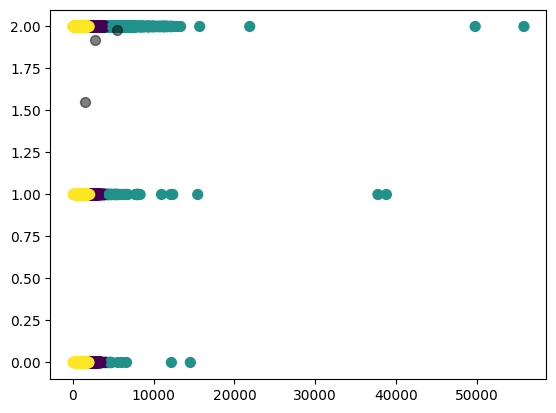

[0 0 2 ... 0 2 2]


In [26]:
print("Agrupamiento segun precio por metro cuadrado y tipo de propiedad")
vec, pr, pb=vector_creator("pxm2","tipo_prop",df_pxm2_kmeans)
y_kmeans = scatter_cluster(vec,pr,pb,3)
print(y_kmeans)
df_pxm2_kmeans['tipo_precio'] = y_kmeans

In [27]:
mean0 = df_pxm2_kmeans.query('tipo_precio == 0')['pxm2'].mean()
mean1 = df_pxm2_kmeans.query('tipo_precio == 1')['pxm2'].mean()
mean2 = df_pxm2_kmeans.query('tipo_precio == 2')['pxm2'].mean()

means = {0:mean0,1:mean1,2:mean2}
tipes = sorted(means.items(), key=lambda x: x[1])

<Axes: title={'center': 'Distribucion variable tipo_precio '}, xlabel='tipo_precio'>

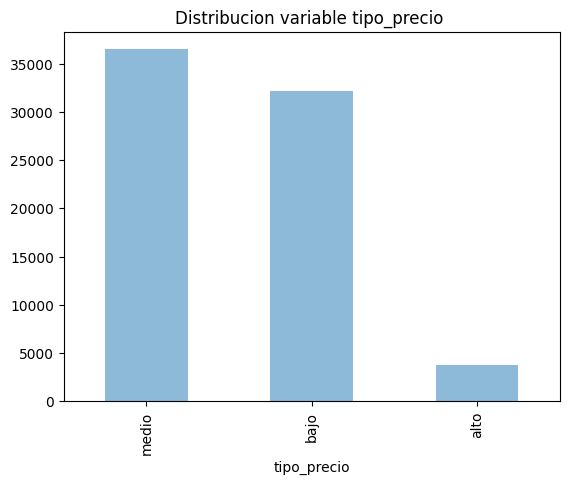

In [28]:
df_pxm2_kmeans['tipo_precio'] = df_pxm2_kmeans['tipo_precio'].apply(lambda x: 'alto' if x == tipes[2][0] else ('bajo' if x == tipes[0][0] else 'medio'))
df_pxm2_kmeans['tipo_precio'].value_counts().plot.bar(alpha=0.5 , title="Distribucion variable tipo_precio ")

maximo de los bajos en kmeans:  2087.72
minimo de los medios en kmeans:  2087.88
maximo de los medios en kmeans:  4061.22
maximo de los altos en kmeans:  4061.61
maximo de los altos en kmeans:  55859.37


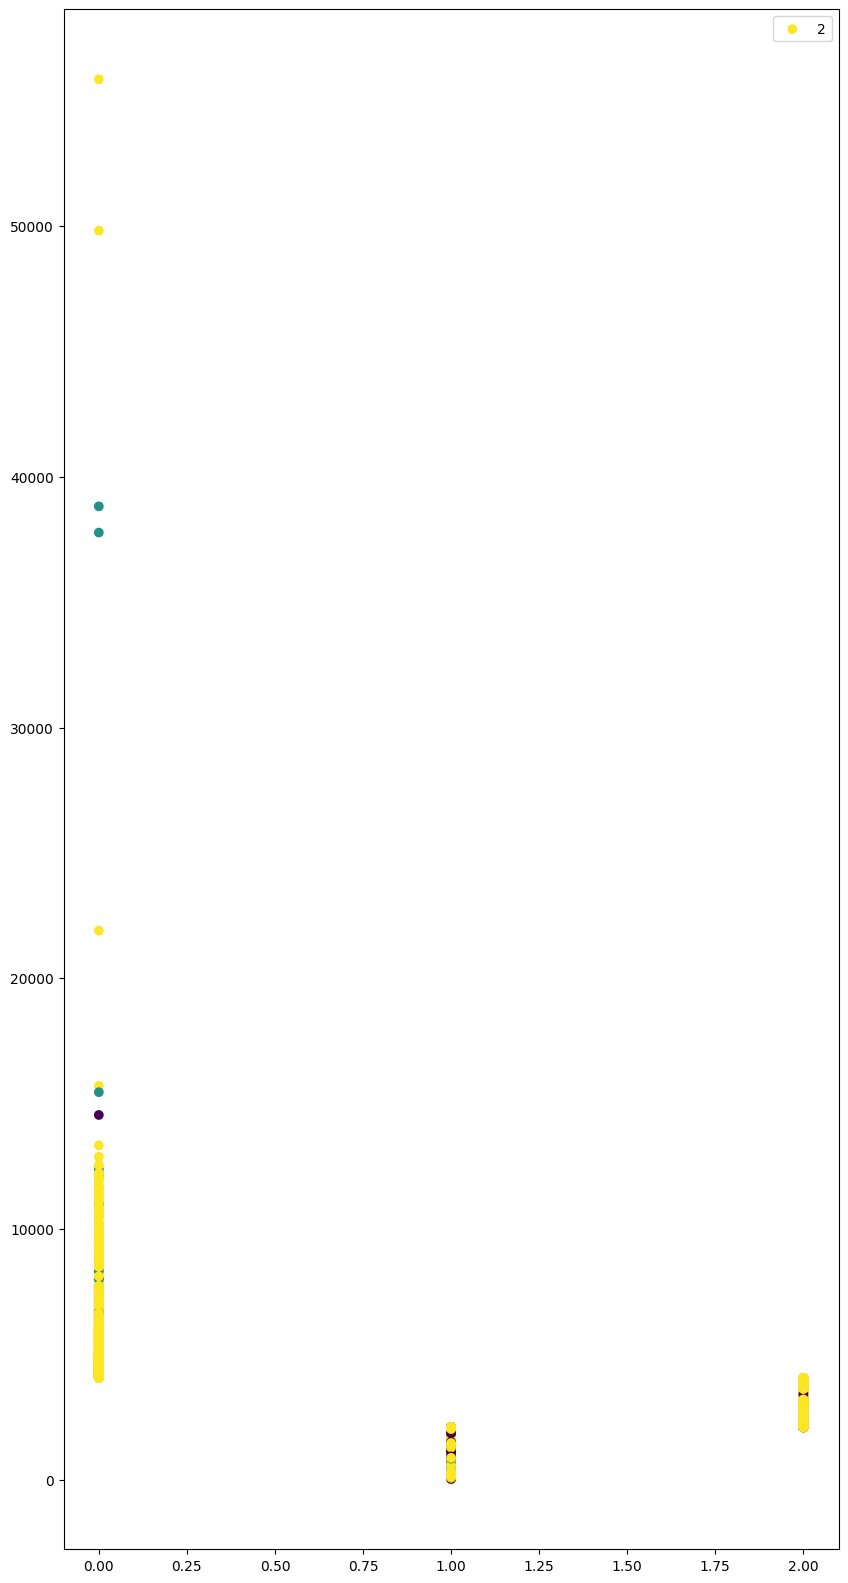

In [29]:
print("maximo de los bajos en kmeans: ", df_pxm2_kmeans[df_pxm2_kmeans["tipo_precio"] == 'bajo']['pxm2'].max())
print("minimo de los medios en kmeans: ", df_pxm2_kmeans[df_pxm2_kmeans["tipo_precio"] == 'medio']['pxm2'].min())
print("maximo de los medios en kmeans: ", df_pxm2_kmeans[df_pxm2_kmeans["tipo_precio"] == 'medio']['pxm2'].max())
print("maximo de los altos en kmeans: ", df_pxm2_kmeans[df_pxm2_kmeans["tipo_precio"] == 'alto']['pxm2'].min())
print("maximo de los altos en kmeans: ", df_pxm2_kmeans[df_pxm2_kmeans["tipo_precio"] == 'alto']['pxm2'].max())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_pxm2_kmeans_aux = df_pxm2_kmeans.copy()
# Convertimos nulos a string 'nan', es decir un valor posible mas
df_pxm2_kmeans_aux["tipo_precio_num"] = le.fit_transform(
    df_pxm2_kmeans["tipo_precio"].astype(str)
)

plt.figure(figsize=(10, 20))
plt.scatter(df_pxm2_kmeans_aux["tipo_precio_num"], df_pxm2_kmeans['pxm2'], c=df_pxm2_kmeans['tipo_prop'] )
plt.legend(df_pxm2_kmeans['tipo_prop'])
plt.show()

maximo de los bajos de la alternativa del tipo de propiedad:  1844.26
minimo de los medios de la alternativa del tipo de propiedad:  1000.0
maximo de los medios de la alternativa del tipo de propiedad:  2826.09
minimo de los altos de la alternativa del tipo de propiedad:  1856.98
maximo de los altos de la alternativa del tipo de propiedad:  55859.37


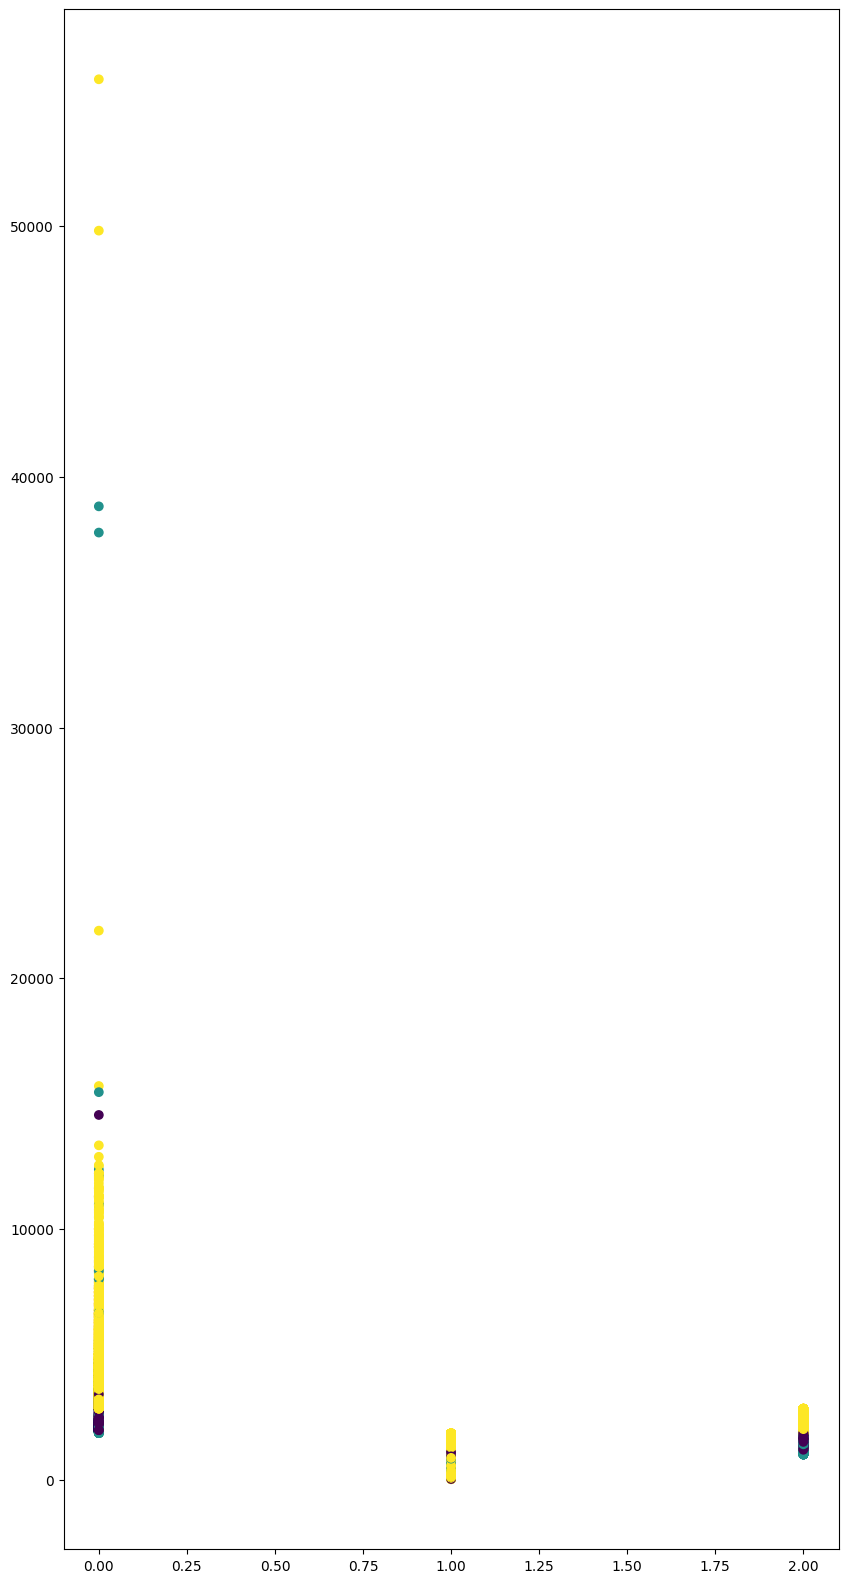

In [30]:
print("maximo de los bajos de la alternativa del tipo de propiedad: ", df_por_tipo_propiedad[df_por_tipo_propiedad["tipo_precio"] == 'bajo']['pxm2'].max())
print("minimo de los medios de la alternativa del tipo de propiedad: ", df_por_tipo_propiedad[df_por_tipo_propiedad["tipo_precio"] == 'medio']['pxm2'].min())
print("maximo de los medios de la alternativa del tipo de propiedad: ", df_por_tipo_propiedad[df_por_tipo_propiedad["tipo_precio"] == 'medio']['pxm2'].max())
print("minimo de los altos de la alternativa del tipo de propiedad: ", df_por_tipo_propiedad[df_por_tipo_propiedad["tipo_precio"] == 'alto']['pxm2'].min())
print("maximo de los altos de la alternativa del tipo de propiedad: ", df_por_tipo_propiedad[df_por_tipo_propiedad["tipo_precio"] == 'alto']['pxm2'].max())

le_aux = LabelEncoder()
df_por_tipo_propiedad_aux = df_por_tipo_propiedad.copy()
# Convertimos nulos a string 'nan', es decir un valor posible mas
df_por_tipo_propiedad_aux["tipo_precio_num"] = le_aux.fit_transform(
    df_por_tipo_propiedad["tipo_precio"].astype(str)
)
df_por_tipo_propiedad_aux['tipo_prop'] = df_por_tipo_propiedad_aux['type_casa'] - df_por_tipo_propiedad_aux['type_dpto']
df_por_tipo_propiedad_aux['tipo_prop'] = df_por_tipo_propiedad_aux['tipo_prop'].apply(lambda x: 1 if x == 1 else (2 if x == -1 else 0))

plt.figure(figsize=(10, 20))
plt.scatter(df_por_tipo_propiedad_aux["tipo_precio_num"], df_por_tipo_propiedad_aux['pxm2'],  c=df_por_tipo_propiedad_aux['tipo_prop'])
plt.show()


In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline

In [32]:
df_caba2 = gpd.read_file("https://raw.githubusercontent.com/claudia-ramos/7506R-1C2024-GRUPO3/main/Datasets/barrios.csv")

In [33]:
df_pxm2_mapa = df_por_tipo_propiedad.copy() #o el que elijamos

In [34]:
df_pxm2_mapa['tipo_precio'] = df_pxm2_mapa['tipo_precio'].apply(lambda x: 1 if x == 'alto' else (0 if x == 'bajo' else 2))

In [35]:
bnds=df_caba2['geometry'].bounds
minx=min(bnds['minx'])
maxx=max(bnds['maxx'])
miny=min(bnds['miny'])
maxy=max(bnds['maxy'])

In [36]:
df_pxm2_mapa=df_pxm2_mapa[(df_pxm2_mapa['latitud']>miny) & (df_pxm2_mapa['latitud']< maxy) & (df_pxm2_mapa['longitud']>minx) & (df_pxm2_mapa['longitud']<maxx)]

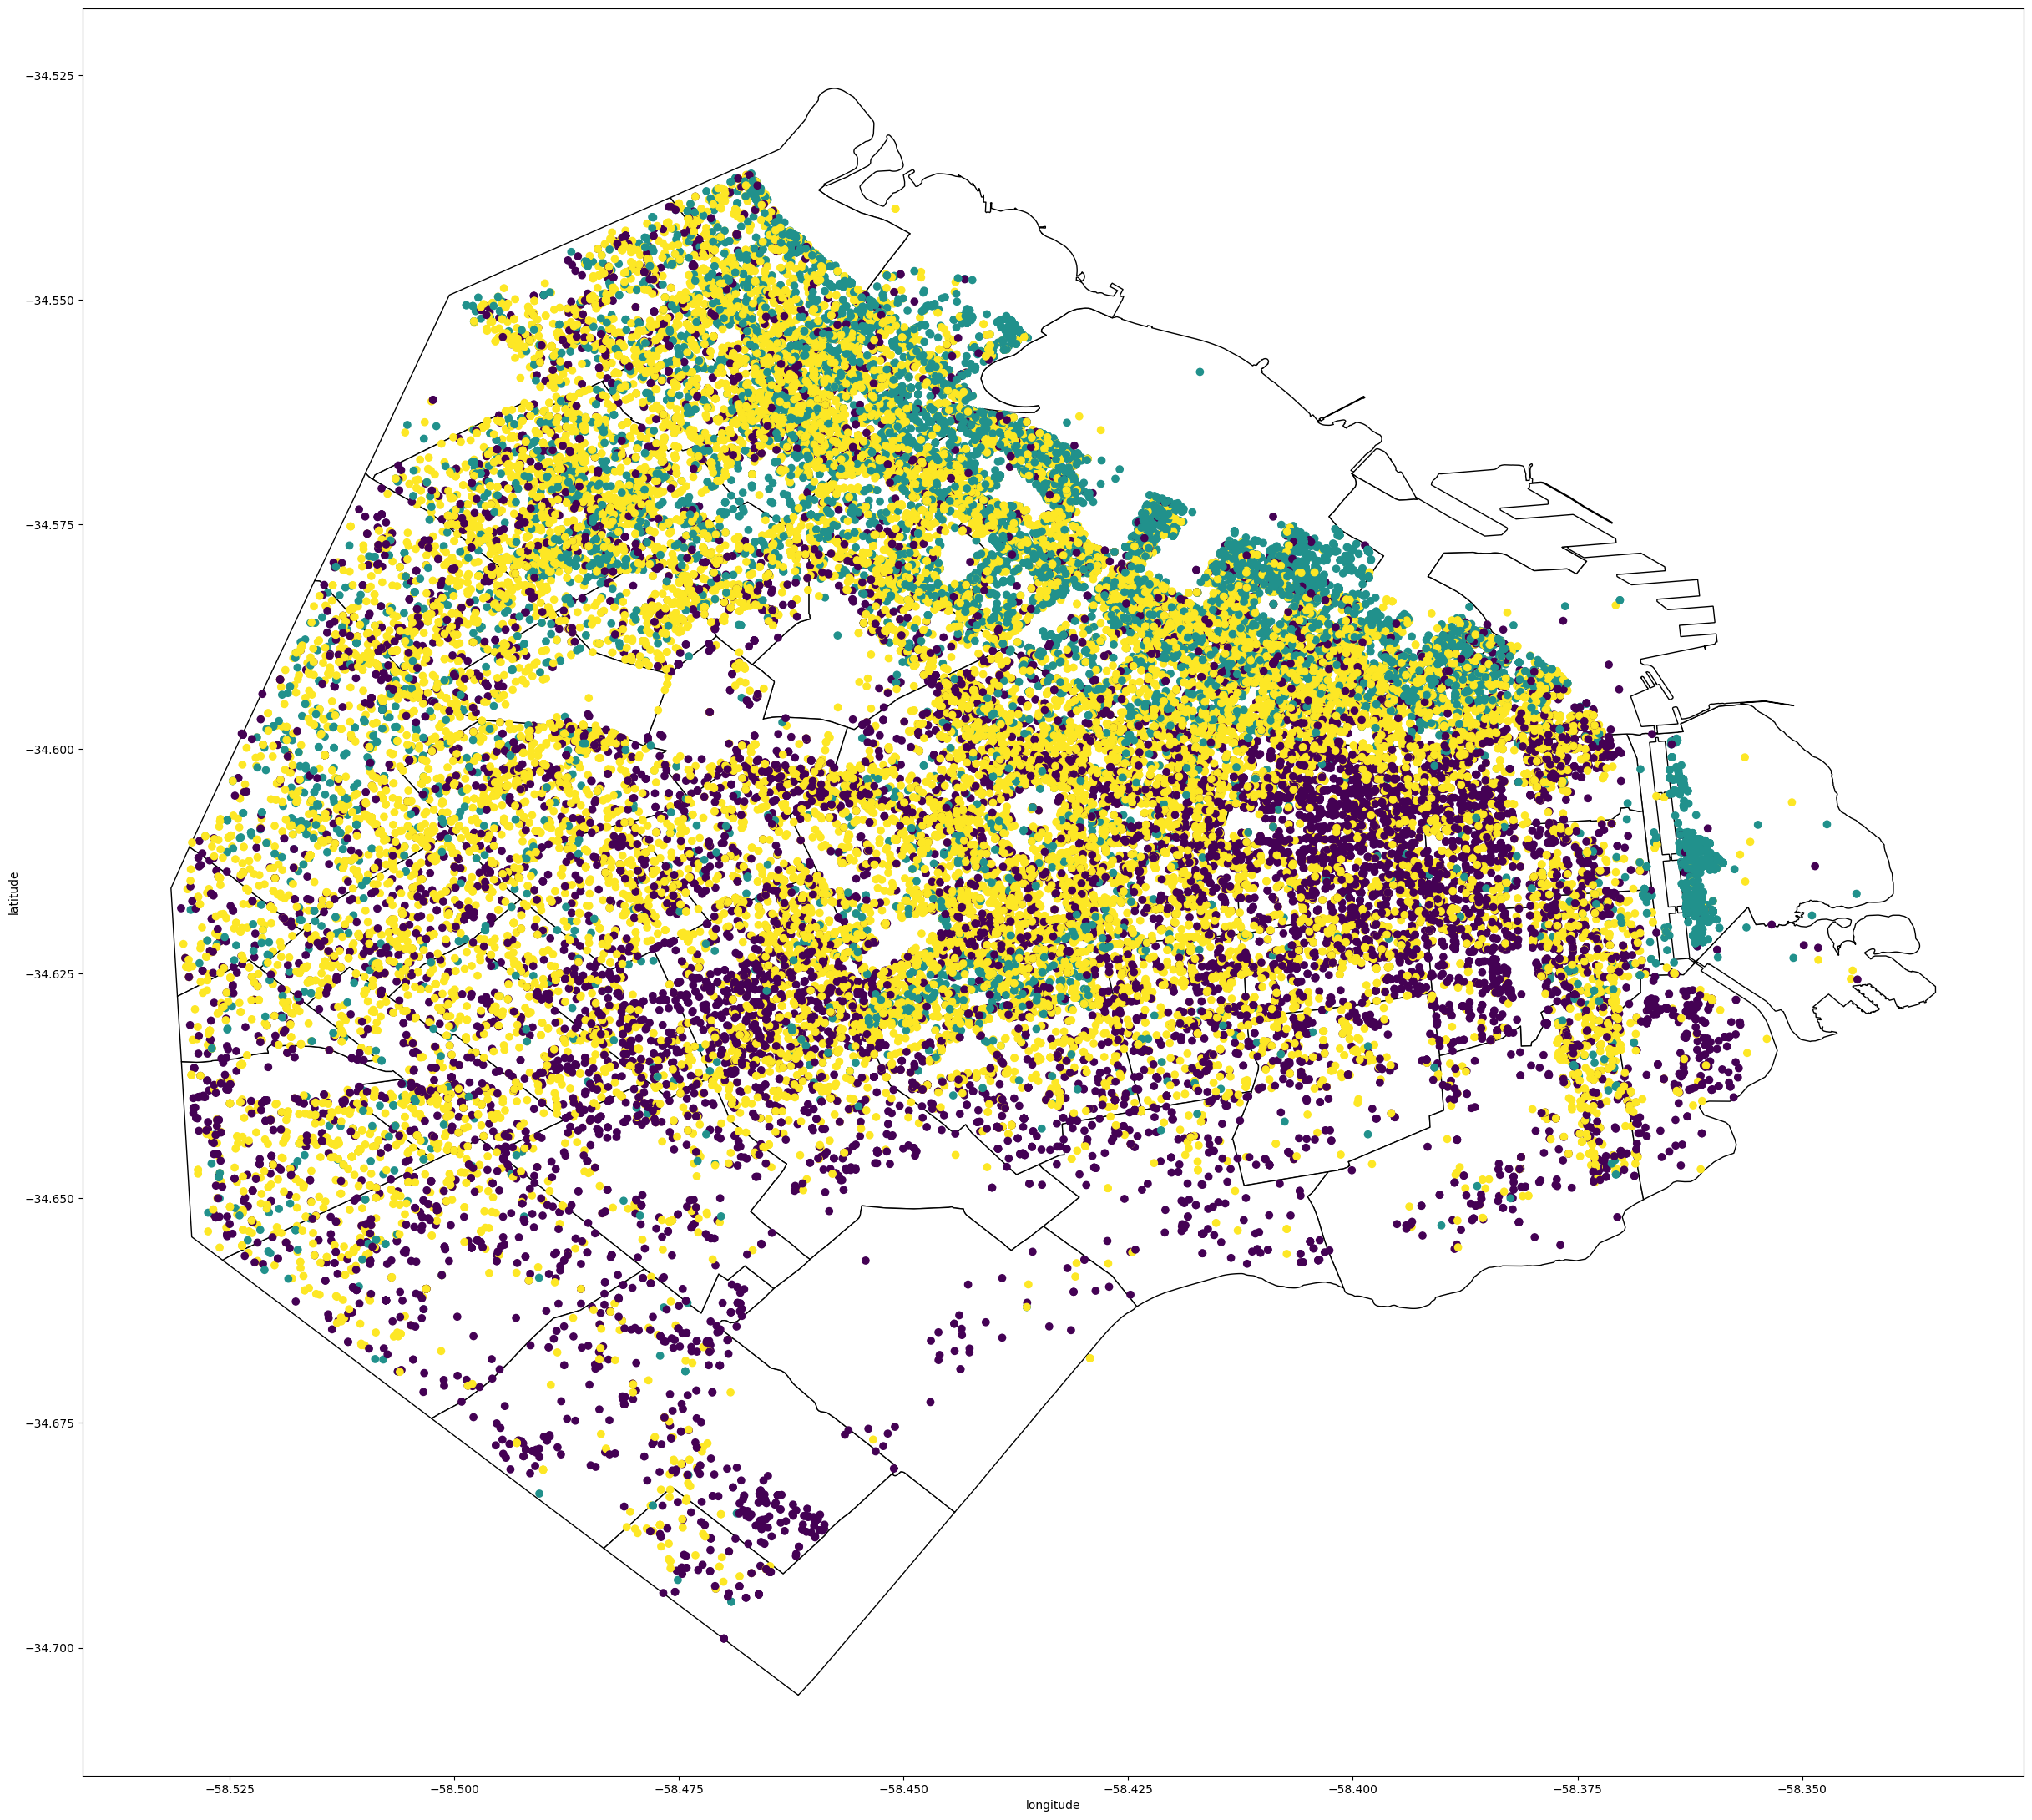

In [37]:
cart, long, lat=vector_creator("longitud","latitud",df_pxm2_mapa)
fig, gax = plt.subplots(figsize=(30, 30))
df_caba2.plot(ax=gax, edgecolor="black", color="white")
gax.scatter(long, lat, c=df_pxm2_mapa['tipo_precio'])
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
plt.show()

In [38]:
columnas_precios = ['tipo_prop']
df_pxm2_kmeans.drop(columnas_precios, axis="columns", inplace=True)

##**Entrenamiento y Predicción**

In [39]:
df_por_tipo_propiedad_aux.head()

latitud   longitud  property_rooms  property_bedrooms  \
11076  -34.228218 -59.554097             5.0                4.0   
97969  -34.589855 -58.406316             5.0                3.0   
453080 -34.623850 -58.377764             2.0                1.0   
277802 -34.573932 -58.474268             1.0                1.0   
97709  -34.621109 -58.466048             2.0                1.0   

        property_surface_total  property_surface_covered  type_casa  \
11076                    202.0                     182.0          0   
97969                    127.0                     103.0          0   
453080                    44.0                      42.0          0   
277802                    34.0                      28.0          0   
97709                     41.0                      41.0          0   

        type_dpto  barrio_Palermo  barrio_Belgrano  barrio_Recoleta  \
11076           1               0                0                1   
97969           1               0                0                1   
453080          1               0                0                0   
277802          1               0                0                0   
97709           1               0                0                0   

        barrio_Caballito  barrio_Villa_Urquiza  barrio_Almagro     pxm2  \
11076                  0                     0               0  2128.71   
97969                  0                     0               0  3307.09   
453080                 0                     0               0  1477.27   
277802                 0                     1               0  2150.00   
97709                  0                     0               0  1658.54   

       tipo_precio  tipo_precio_num  tipo_prop  
11076        medio                2          2  
97969         alto                0          2  
453080        bajo                1          2  
277802       medio                2          2  
97709         bajo                1          2

In [40]:
#Eliminar las columnas pxm2 y tipo_precio
df_por_tipo_propiedad_aux.drop(['tipo_precio', 'pxm2','tipo_prop'], axis="columns", inplace=True)
df_por_tipo_propiedad_aux.head()

latitud   longitud  property_rooms  property_bedrooms  \
11076  -34.228218 -59.554097             5.0                4.0   
97969  -34.589855 -58.406316             5.0                3.0   
453080 -34.623850 -58.377764             2.0                1.0   
277802 -34.573932 -58.474268             1.0                1.0   
97709  -34.621109 -58.466048             2.0                1.0   

        property_surface_total  property_surface_covered  type_casa  \
11076                    202.0                     182.0          0   
97969                    127.0                     103.0          0   
453080                    44.0                      42.0          0   
277802                    34.0                      28.0          0   
97709                     41.0                      41.0          0   

        type_dpto  barrio_Palermo  barrio_Belgrano  barrio_Recoleta  \
11076           1               0                0                1   
97969           1               0                0                1   
453080          1               0                0                0   
277802          1               0                0                0   
97709           1               0                0                0   

        barrio_Caballito  barrio_Villa_Urquiza  barrio_Almagro  \
11076                  0                     0               0   
97969                  0                     0               0   
453080                 0                     0               0   
277802                 0                     1               0   
97709                  0                     0               0   

        tipo_precio_num  
11076                 2  
97969                 0  
453080                1  
277802                2  
97709                 1

In [41]:
df_por_tipo_propiedad_train = df_por_tipo_propiedad_aux.drop(['property_bedrooms', 'property_surface_covered', 'tipo_precio_num'], axis="columns")
tipo_price_train = df_por_tipo_propiedad_aux["tipo_precio_num"]

In [42]:
x_train, x_test, y_train, y_test = train_test_split(df_por_tipo_propiedad_train,
                                                    tipo_price_train,
                                                    test_size=0.2,
                                                    random_state=1)

###Arbol de decision

In [43]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

#Cantidad de combinaciones que quiero porbar
n=20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,25)),
               'ccp_alpha':np.linspace(0,0.0002,n)}

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = KFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              random_state=20,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train, y_train);

In [44]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'max_depth': 22, 'criterion': 'entropy', 'ccp_alpha': 6.31578947368421e-05}
0.6883278960066901


In [45]:
#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)


DecisionTreeClassifier(ccp_alpha=6.31578947368421e-05, criterion='entropy',
                       max_depth=22)

In [47]:
y_pred=arbol.predict(x_test)

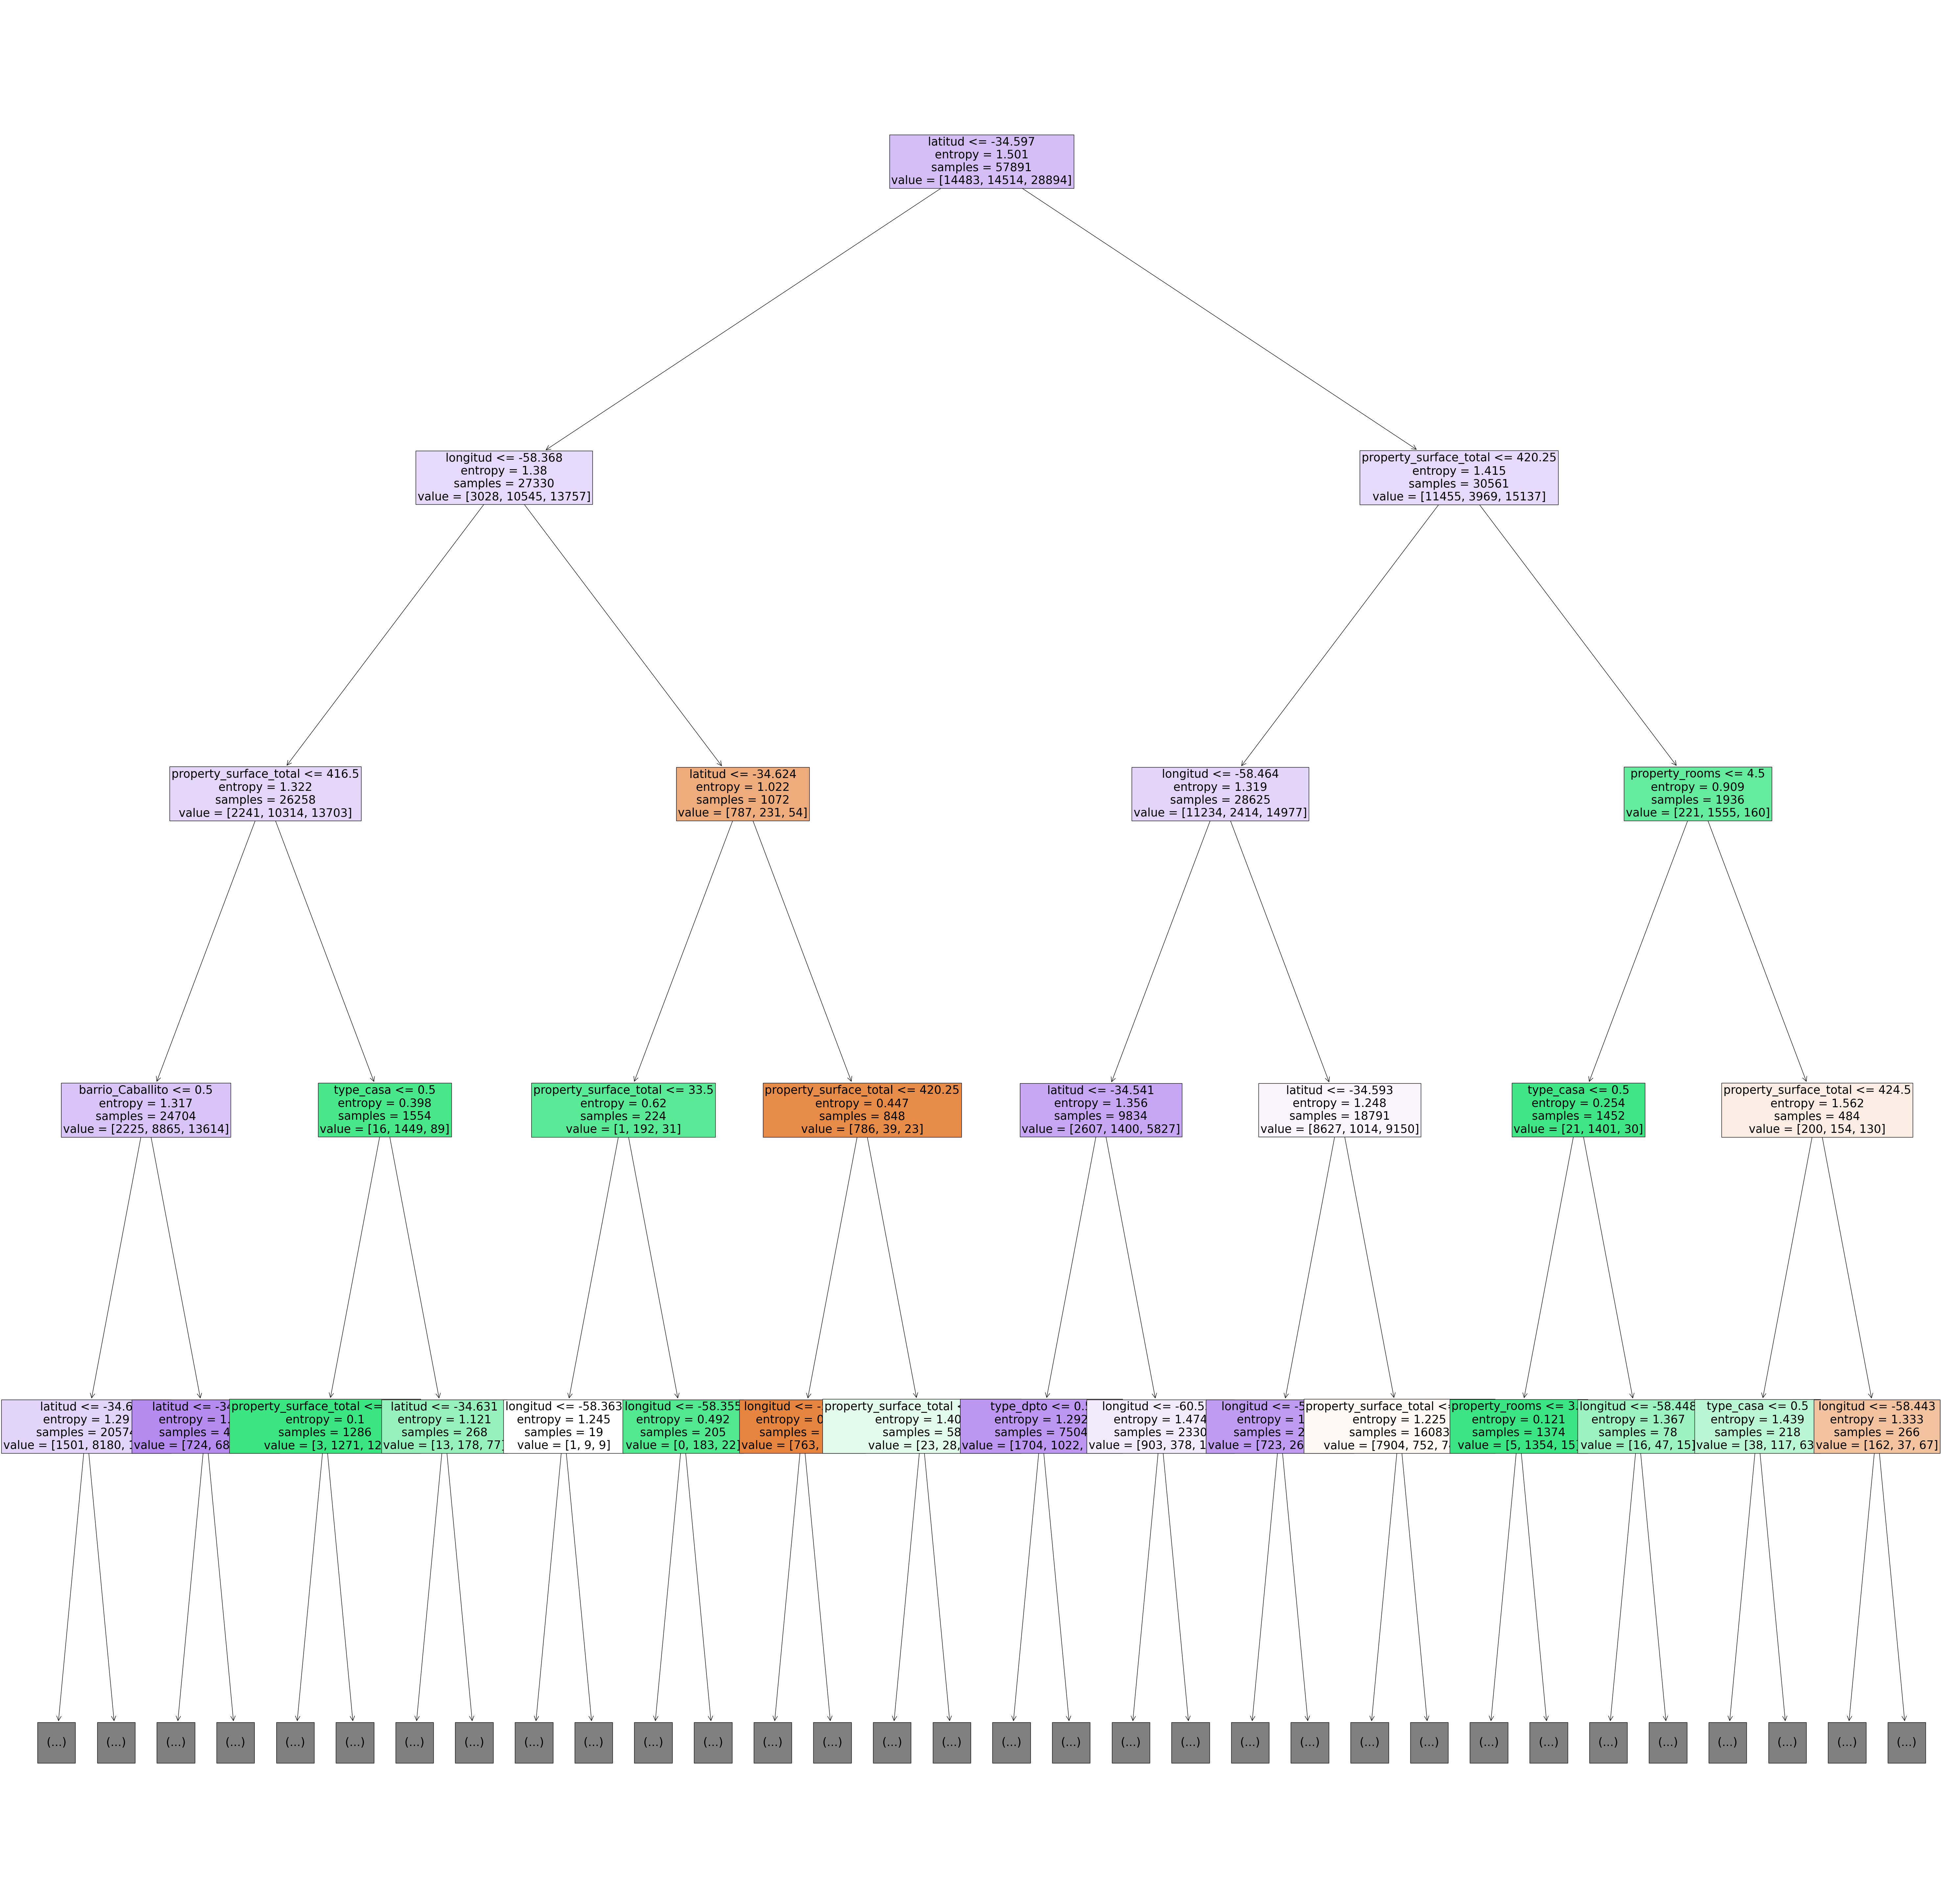

In [48]:
import sklearn as sk
plt.figure(figsize=(75,75))
sk.tree.plot_tree(arbol,feature_names=x_test.columns,filled=True,max_depth=4,fontsize=25)
plt.show()

Para el arbol de decicion se usaron 10 folds y la metrica que se considero fue F1.

In [49]:
#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_por_tipo_propiedad_train.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

barrio_Villa_Urquiza: 0.0015308553621908578
barrio_Almagro: 0.001865954582578916
barrio_Recoleta: 0.002919274647686444
barrio_Palermo: 0.0036736108878090102
barrio_Belgrano: 0.0037745572493333886
type_casa: 0.01193753988197849
barrio_Caballito: 0.013049932352143535
type_dpto: 0.018293748312978964
property_rooms: 0.0562269672391999
longitud: 0.2675782638576538
property_surface_total: 0.2696037644056725
latitud: 0.34954553122077436


Vemos que el arbol de decision tomo a la latitud como atributo mas importante, es decir es el atributo que mas aporta informacion al arbol. Y los otros atributos que mas aprotaron informacion fueron la longitud y la superficie total de la propiedad.

Lo primero que hara el arbol es dividir el dataset en dos subconjuntos, para esto se fija primero en el valor de la latitud de cada observacion, colocara en un subconjunto las observaciones con la latitud <= a -34,598 y en otro las observaciones > a -34,598.

Al subconjunto con la latitud <= -34,598 lo dividira endos subconjuntos mas y para ello se fija en el valor de la longitud, seraparando las observaciones con una longitud <= a -58,368 en un subconjunto y las observaciones con la longitud > -58,368 en otro subconjunto.

Y para el subconjunto con la latitud que tiene > -34.598 lo dividira en dos subconjuntos fijandose en el valor de la superficie total de cada observacion, las observaciones que tienen una superficie <= a 420,481 los junta en un subconjunto y el resto de las observaciones en otro subconjunto.

In [50]:
#Metricas en test
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy: "+str(accuracy))
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred, average='weighted')
precision=precision_score(y_test,y_pred,average='weighted')

print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.6870033856145927
Recall: 0.6870033856145927
Precision: 0.686545965587625
f1 score: 0.6864428197380493


Text(50.722222222222214, 0.5, 'True')

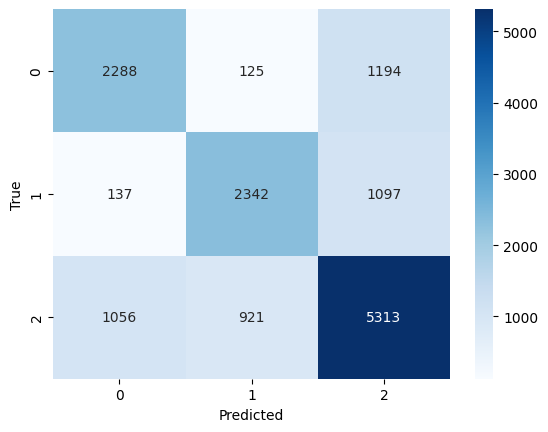

In [51]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Exportación del modelo

In [52]:
joblib.dump(arbol,'arbol_de_decision.joblib')

['arbol_de_decision.joblib']

###Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
#Cantidad de combinaciones que quiero porbar
n=10
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':["entropy", "gini"],
               'min_samples_leaf':list(range(5,10)),
               'min_samples_split':list(range(5,10)),
               'n_estimators':list(range(25,50))}
#Cantidad de splits para el Cross Validation
folds=10
#Kfold estratificado
kfoldcv = KFold(n_splits=folds)
#Clasificador
base_tree = RandomForestClassifier(oob_score=True, random_state=1, n_jobs=-1)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score, average='micro')
#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              random_state=20,
                              n_iter=n)
#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train, y_train);

In [54]:
#Mejores hiperparametros del Random Forest
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'n_estimators': 46, 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'entropy'}
0.7069836068703941


In [55]:
best_estimator=randomcv.best_estimator_
y_pred = best_estimator.predict(x_test)

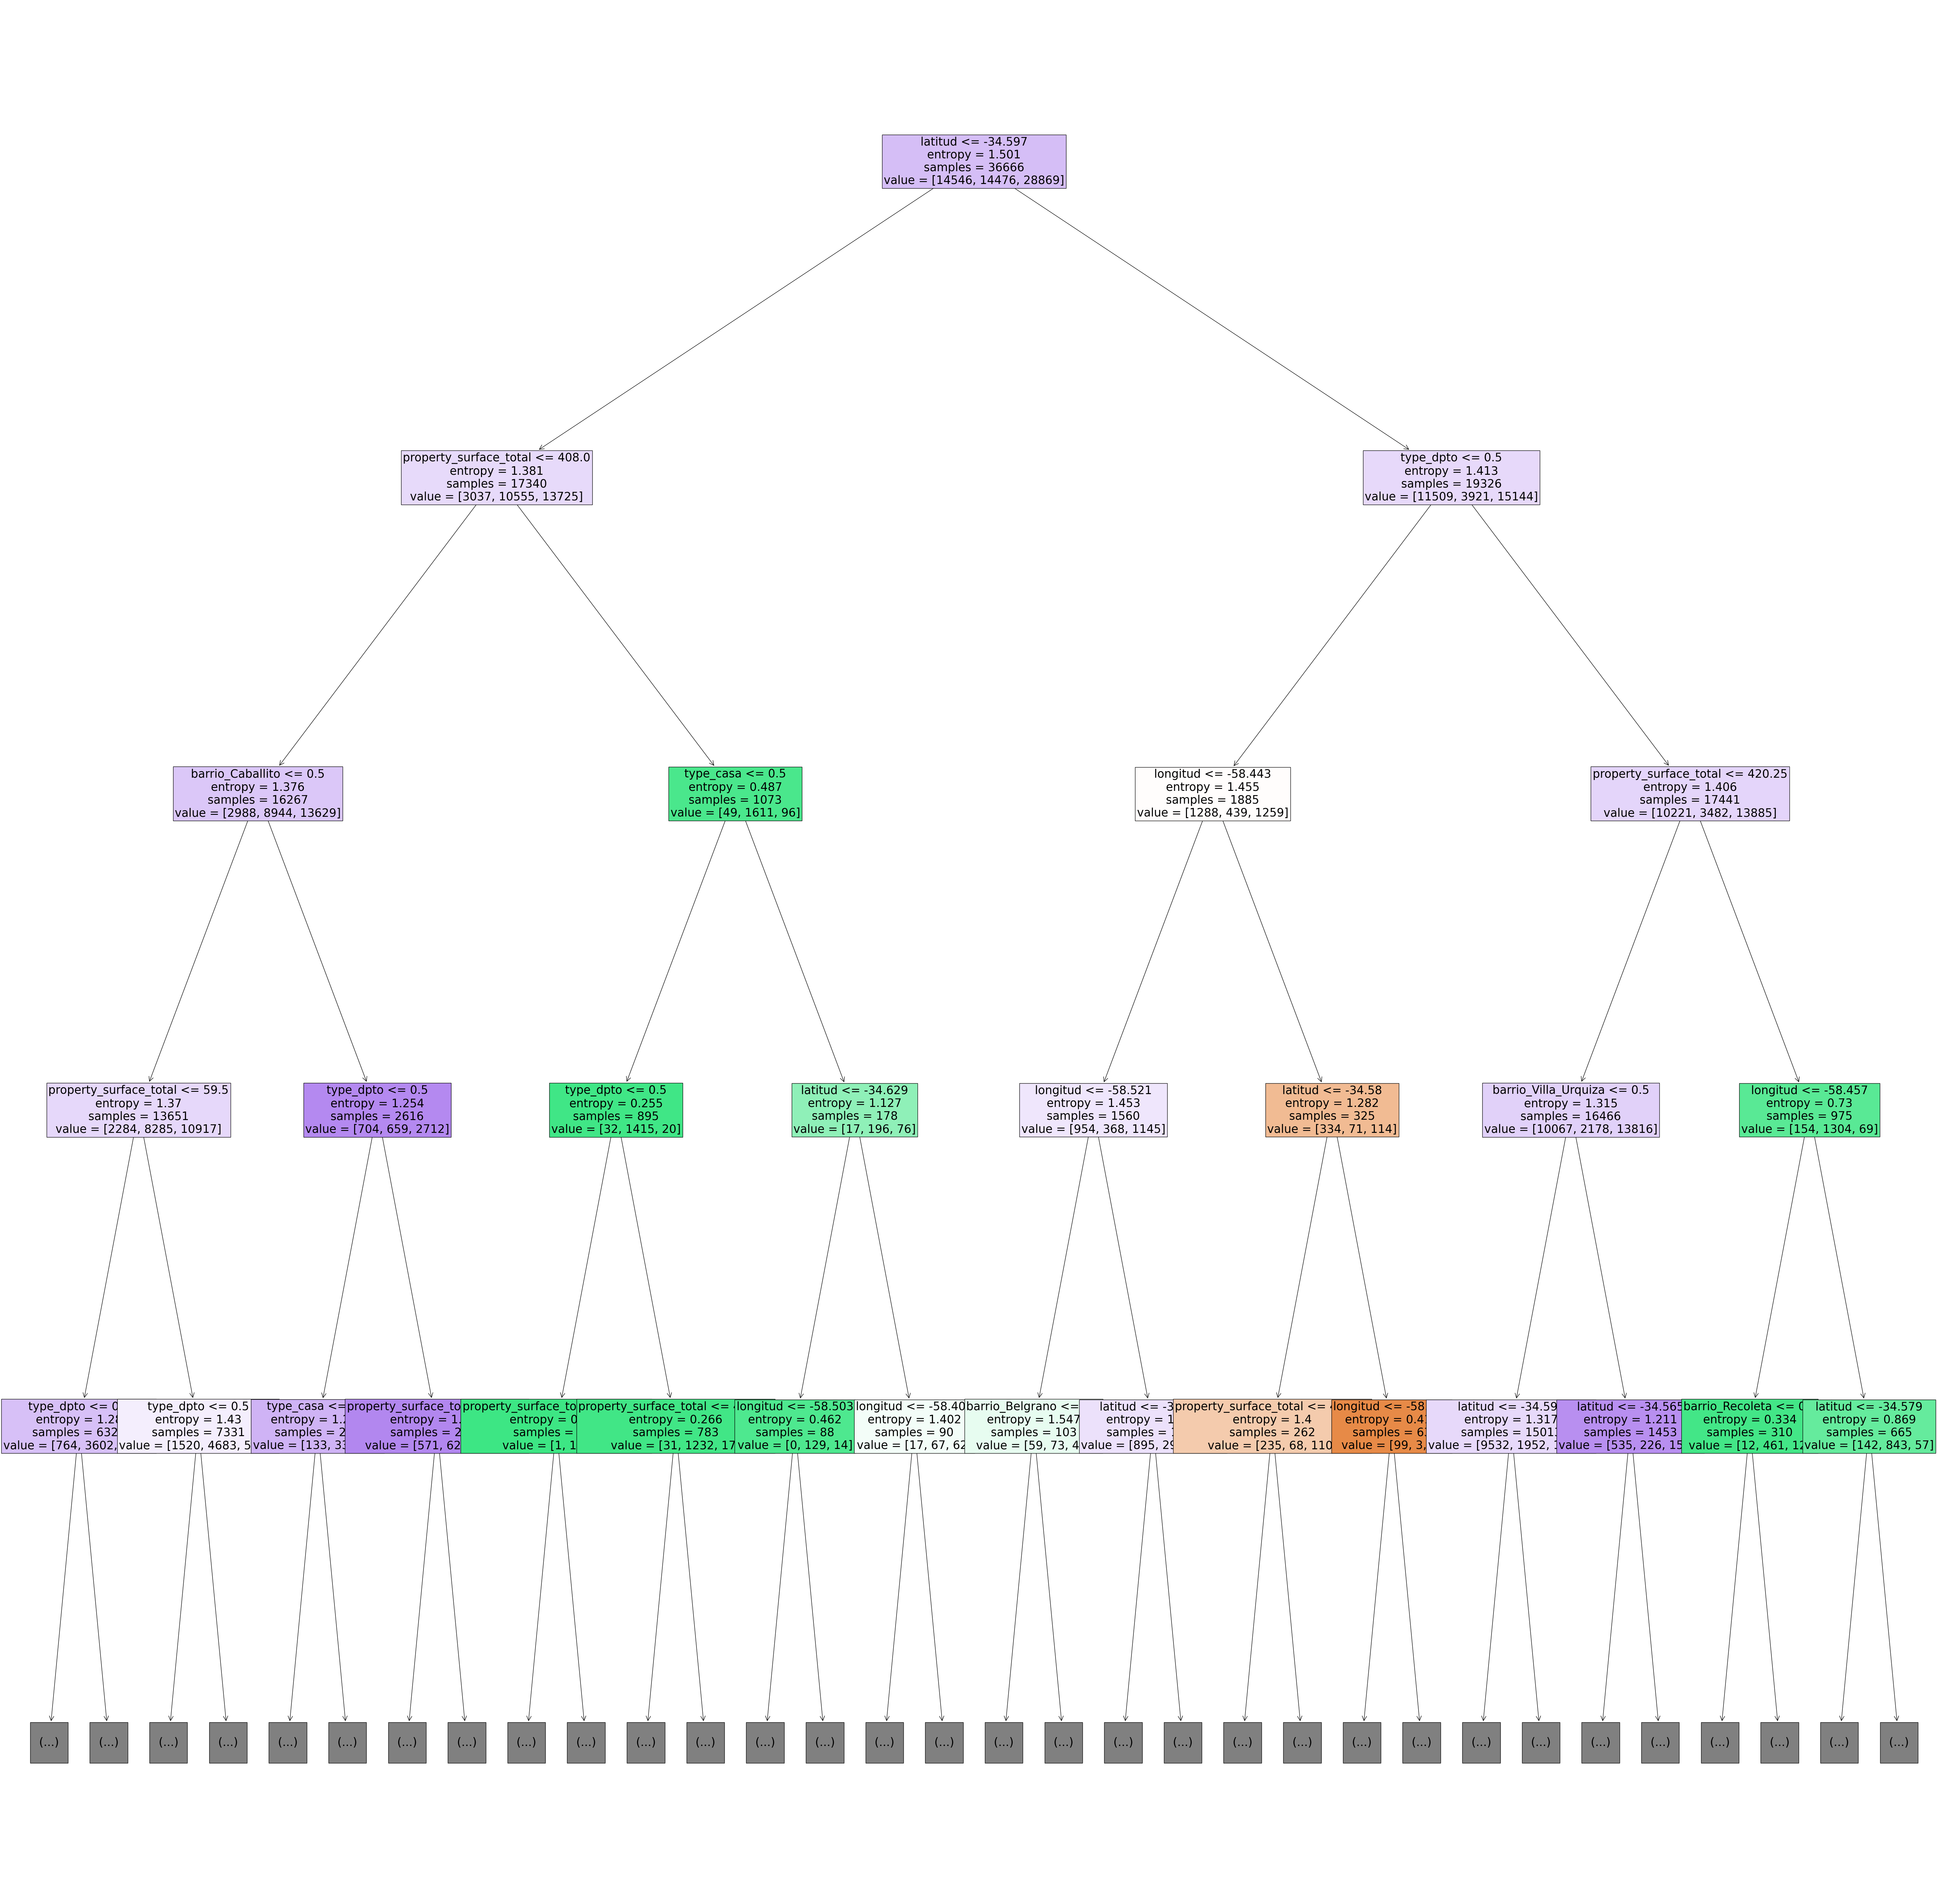

In [56]:
est = best_estimator.estimators_[len(best_estimator.estimators_)-1]
plt.figure(figsize=(75,75))
sk.tree.plot_tree(est,feature_names=x_test.columns,filled=True,max_depth=4,fontsize=25)
plt.show()

In [57]:
#Metricas en test
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy: "+str(accuracy))
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred, average='weighted')
precision=precision_score(y_test,y_pred,average='weighted')

print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7082152974504249
Recall: 0.7082152974504249
Precision: 0.7203704710934056
f1 score: 0.7021861417029093


Text(50.722222222222214, 0.5, 'True')

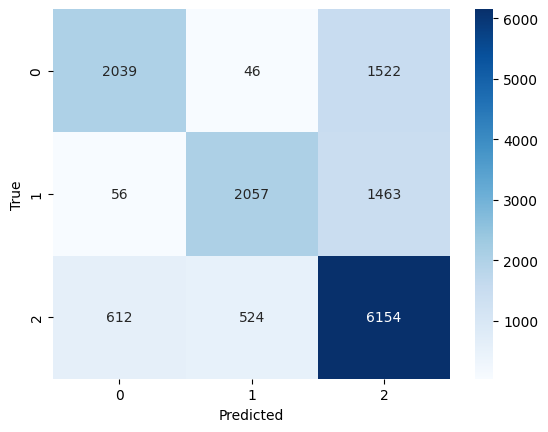

In [58]:
#Matriz de confusion
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Exportación del modelo

In [59]:
joblib.dump(best_estimator,'random_forest.joblib')

['random_forest.joblib']

### Regresion logistica

Decidimos usar la regrecion logistica para como metodo de clasificacion para predecir el tipo de precio.

In [60]:
from sklearn.linear_model import LogisticRegressionCV

scorer_fn = make_scorer(f1_score, average='micro')
lr = LogisticRegressionCV(max_iter=10000,
                          tol=0.00001,
                          cv=10,
                          random_state=1,
                          n_jobs=-1,
                          scoring=scorer_fn)
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)




In [61]:
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy: "+str(accuracy))
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred, average='weighted')
precision=precision_score(y_test,y_pred,average='weighted')

print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.5756235749326332
Recall: 0.5756235749326332
Precision: 0.5972985303676643
f1 score: 0.5292967341977246


In [62]:
print(lr.score)

<bound method LogisticRegressionCV.score of LogisticRegressionCV(cv=10, max_iter=10000, n_jobs=-1, random_state=1,
                     scoring=make_scorer(f1_score, average=micro), tol=1e-05)>


Text(50.722222222222214, 0.5, 'True')

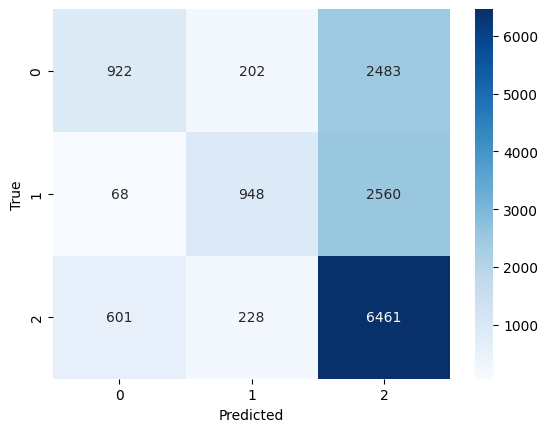

In [63]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Exportación del modelo

In [64]:
joblib.dump(lr,'regresion_logistica.joblib')

['regresion_logistica.joblib']

# **Regresion**

In [65]:
x_train = df_train.copy()
y_train = price_train.copy()
x_test = df_test.copy()
y_test = price_test.copy()

##K-Nearest Neighbours

In [66]:
from sklearn import metrics
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero porbar
n=15

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30),
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev'],
              'leaf_size': list(range(20, 50)),
              'p':[1,2,3]
             }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = KFold(n_splits=folds)

#Scorer
scorer = make_scorer(metrics.mean_absolute_error)

#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search
rand = RandomizedSearchCV(knn, params_grid, cv=kfoldcv, scoring=scorer, n_iter=n, random_state = 2, n_jobs = -1)

rand.fit(x_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=KNeighborsRegressor(), n_iter=15, n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': [20, 21, 22, 23, 24, 25,
                                                      26, 27, 28, 29, 30, 31,
                                                      32, 33, 34, 35, 36, 37,
                                                      38, 39, 40, 41, 42, 43,
                                                      44, 45, 46, 47, 48, 49],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(1, 30),
                                        'p': [1, 2, 3],
                                        'weights': ['distance', 'uniform']},
                   random_state=2, scoring=make_scorer(mean_absolute_error))

In [67]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'uniform', 'p': 1, 'n_neighbors': 21, 'metric': 'chebyshev', 'leaf_size': 29, 'algorithm': 'ball_tree'}
70669.18423838983


In [68]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

In [69]:
#Metricas para evaluar modelos
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

#Mean Absolute Error
mae = metrics.mean_absolute_error(
    y_true  = y_test,
    y_pred  = y_pred,
)

print(f"El score (mae) de test es: {mae}")
print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")

El score (mae) de test es: 76742.2672689928
El error (mse) de test es: 46609295330.97465
El error (rmse) de test es: 215891.86027030906


In [70]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_train)

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred,
        squared = False
       )

#Mean Absolute Error
mae = metrics.mean_absolute_error(
    y_true  = y_train,
    y_pred  = y_pred,
)

print(f"El score (mae) de train es: {mae}")
print(f"El error (mse) de train es: {mse}")
print(f"El error (rmse) de train es: {rmse}")

El score (mae) de train es: 66010.95233659816
El error (mse) de train es: 28725610772.526432
El error (rmse) de train es: 169486.31441071114


Las metricas entre train y test nos indica que no hay un comportamiento de overfiting.

Exportación del modelo

In [71]:
joblib.dump(best_knn,'knn_regresion.joblib')

['knn_regresion.joblib']

## XGBoost

In [72]:
from sklearn import metrics
from sklearn.metrics import make_scorer

#Creo el modelo y lo entreno

import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#cantidad de iteraciones
n=10

#Grilla de Parámetros
params = {
    'learning_rate': np.linspace(0.01, 0.9, 200),
    'lambda': np.linspace(0,10,20),
    'n_estimators':range(10,180,10),
    'gamma':np.linspace(0,9,20),
    'subsample': np.linspace(0,1,30),
    'max_depth': [2,3,4,5,6,7],
    'eta': np.arange(0.2, 0.7, 0.1),
}

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = KFold(n_splits=folds)

#Scorer
scorer = make_scorer(metrics.mean_absolute_error)

#Clasificador XGBoots

xgb_model = xgb.XGBRegressor(random_state=0, n_estimators=100)

#Random Search
rand = RandomizedSearchCV(xgb_model,
                          params,
                          cv=kfoldcv,
                          scoring=scorer,
                          n_iter=n,
                          random_state = 1,
                          n_jobs = -1)

rand.fit(x_train, y_train)

#Mejores hiperparametros del arbol
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'subsample': 0.6206896551724138, 'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.7747738693467336, 'lambda': 10.0, 'gamma': 1.894736842105263, 'eta': 0.5000000000000001}
55663.54823947504


In [73]:
#Mejor estimador
best_xgb=rand.best_estimator_

#Predicción con mejor estimador
y_pred_xgb=best_xgb.predict(x_test)

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred_xgb,
        squared = True
       )


#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred_xgb,
        squared = False
       )

#Mean Absolute Error
mae = metrics.mean_absolute_error(
    y_true  = y_test,
    y_pred  = y_pred_xgb,
)

print(f"El score (mae) de test es: {mae}")
print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")

El score (mae) de test es: 62092.09001991371
El error (mse) de test es: 28785232539.25582
El error (rmse) de test es: 169662.11285745507


In [74]:
#Predicción con mejor estimador
y_pred=best_xgb.predict(x_train)

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred,
        squared = True
       )


#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred,
        squared = False
       )

#Mean Absolute Error
mae = metrics.mean_absolute_error(
    y_true  = y_train,
    y_pred  = y_pred,
)

print(f"El score (mae) de train es: {mae}")
print(f"El error (mse) de train es: {mse}")
print(f"El error (rmse) de train es: {rmse}")

El score (mae) de train es: 54599.47846318985
El error (mse) de train es: 15399736895.39954
El error (rmse) de train es: 124095.67637673579


Las metricas entre train y test nos indica que no hay un comportamiento de overfiting.

Exportación del modelo

In [75]:
joblib.dump(best_xgb,'xgboost.joblib')

['xgboost.joblib']

## Gradient Boost

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#cantidad de iteraciones
n=6

#Grilla de Parámetros
params_grid={ 'loss':['huber'],
              'max_depth':list(range(1,5)),
              'criterion':['friedman_mse','squared_error']
             }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = KFold(n_splits=folds)

#Scorer
scorer = make_scorer(metrics.mean_absolute_error)

#Clasificador Gradient Boost
gb=GradientBoostingRegressor()

#Random Search
rand = RandomizedSearchCV(gb,
                          params_grid,
                          cv=kfoldcv,
                          scoring=scorer,
                          n_iter=n,
                          random_state = 2,
                          n_jobs = -1)

rand.fit(x_train, y_train)

#Mejores hiperparametros del arbol
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'max_depth': 1, 'loss': 'huber', 'criterion': 'squared_error'}
68309.0556354723


In [77]:
#Mejor estimador
best_gb=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_gb.predict(x_test)

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

#Mean Absolute Error
mae = metrics.mean_absolute_error(
    y_true  = y_test,
    y_pred  = y_pred,
)

print(f"El score (mae) de test es: {mae}")
print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")

El score (mae) de test es: 74425.37505393875
El error (mse) de test es: 58601681095.59148
El error (rmse) de test es: 242077.84098424102


In [78]:
#Mejor estimador
best_gb=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_gb.predict(x_train)

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred,
        squared = True
       )


#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred,
        squared = False
       )

#Mean Absolute Error
mae = metrics.mean_absolute_error(
    y_true  = y_train,
    y_pred  = y_pred,
)

print(f"El score (mae) de train es: {mae}")
print(f"El error (mse) de train es: {mse}")
print(f"El error (rmse) de train es: {rmse}")

El score (mae) de train es: 68139.92347956744
El error (mse) de train es: 41242603729.11471
El error (rmse) de train es: 203082.75093940084


Las metricas entre train y test nos indica que no hay un comportamiento de overfiting.

Exportación del modelo

In [79]:
joblib.dump(best_gb,'gradient_boost.joblib')

['gradient_boost.joblib']

##Modelo a seleccionar

El modelo que dio un error menor fue el XGBoost, por ende seleccionamos dicho modelo para preedcir nuevas observasiones futuras.

In [80]:
#Predicción con mejor estimador
y_pred_aux = best_xgb.predict(x_test)


df_predict = x_test.copy()
df_predict['Valores_reales'] = y_test['property_price'].tolist()
df_predict['Valores_predichos'] = y_pred_aux


display(df_predict.head())

latitud   longitud  property_rooms  property_bedrooms  \
49692  -34.588223 -58.388713             3.0                2.0   
87930  -34.554614 -58.464263             4.0                3.0   
101029 -34.622605 -58.375499             3.0                2.0   
146155 -34.572891 -58.478185             2.0                1.0   
203779 -34.580126 -58.425198             2.0                1.0   

        property_surface_total  property_surface_covered  type_casa  \
49692                    210.0                     200.0          0   
87930                    124.0                     124.0          0   
101029                   117.0                     110.0          0   
146155                    52.0                      47.0          0   
203779                    42.0                      36.0          0   

        type_dpto  barrio_Palermo  barrio_Belgrano  barrio_Recoleta  \
49692           1               0                0                1   
87930           1               0                1                0   
101029          1               0                0                0   
146155          1               0                0                0   
203779          1               1                0                0   

        barrio_Caballito  barrio_Villa_Urquiza  barrio_Almagro  \
49692                  0                     0               0   
87930                  0                     0               0   
101029                 0                     0               0   
146155                 0                     1               0   
203779                 0                     0               0   

        Valores_reales  Valores_predichos  
49692         700000.0      665463.062500  
87930         415000.0      457882.875000  
101029        180000.0      253936.437500  
146155        126000.0      134614.218750  
203779         88000.0      124499.226562